# User Overview analysis

The goal of this section is to understand the dataset using visual and quantitative methods to get a sense of the story it tells.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import sys

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

sns.set(style="ticks", color_codes=True)
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('data/clean_data.csv',low_memory=False)
data = data.drop(['Unnamed: 0'], axis=1)
data['Number of sessions'] = 1

In [3]:
data = data.groupby(by = ['MSISDN/Number'], as_index = False).agg('sum')

#### Remove outliers

In [4]:
all_columns = list(data.iloc[:,1:].columns)
for x in all_columns:
    try:
        data[x] = np.where(data[x] > data[x].quantile(0.95), data[x].quantile(0.50), data[x])
    except TypeError:
        continue

### Overview of the users’ behavior on applications.

In [5]:
data = data[['MSISDN/Number','Number of sessions','Dur. (ms).1','Social Media DL (Bytes)','Social Media UL (Bytes)','Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)','Email UL (Bytes)', 'Youtube DL (Bytes)','Youtube UL (Bytes)','Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)','Total UL (Bytes)', 'Total DL (Bytes)']]

In [6]:
data['Dur. (min)'] = data['Dur. (ms).1'] /(6e+7)
data['Social Media Total (Gigabytes)'] = (data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)'])/(1e+9)
data['Google Total(Gigabytes)'] = (data['Google DL (Bytes)'] + data['Google UL (Bytes)'])/(1e+9)
data['Email Total(Gigabytes)'] = (data['Email DL (Bytes)'] + data['Email UL (Bytes)'])/(1e+9)
data['Youtube Total(Gigabytes)'] = (data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)'])/(1e+9)
data['Netflix Total(Gigabytes)'] = (data['Netflix DL (Bytes)'] + data['Netflix UL (Bytes)'])/(1e+9)
data['Gaming Total(Gigabytes)'] = (data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)'])/(1e+9)
data['Other Total(Gigabytes)'] = (data['Other DL (Bytes)'] + data['Other UL (Bytes)'])/(1e+9)
data['Total Total(Gigabytes)'] = (data['Total UL (Bytes)'] + data['Total DL (Bytes)'])/(1e+9)

#### A Non-Graphical Univariate Analysis

In [7]:
data_description = data.describe(include='all')

#drop stats on MSISDN 
data_description = data_description.drop('MSISDN/Number', axis=1)

data_mean = data_description[data_description.index == 'mean'].transpose()
data_std = data_description[data_description.index == 'std'].transpose()
#Standard deviation is the square root of the variance
data_var = (data_description[data_description.index == 'std'].transpose()) ** 2

data_count = data_description[data_description.index == 'count'].transpose()
data_min = data_description[data_description.index == 'min'].transpose()
data_max = data_description[data_description.index == 'max'].transpose()

#percentiles
data_25th = data_description[data_description.index == '25%'].transpose()
data_50th = data_description[data_description.index == '50%'].transpose()
data_75th = data_description[data_description.index == '75%'].transpose()

#### A Graphical Univariate Analysis

In [8]:
plot_list = list(data.iloc[:,19:].columns)

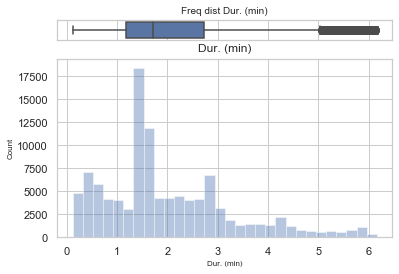

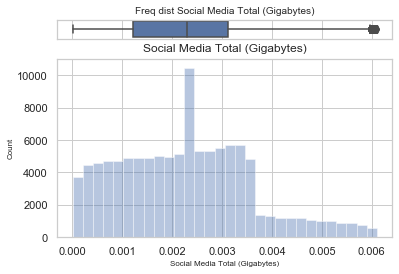

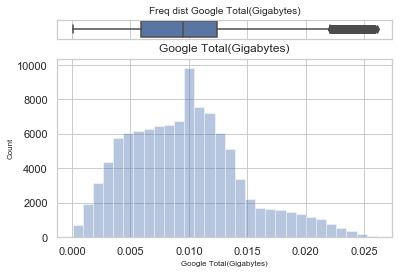

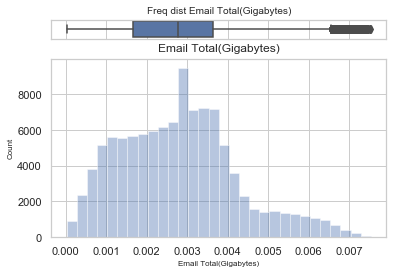

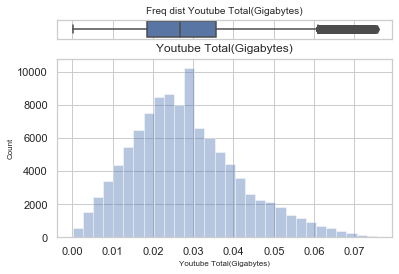

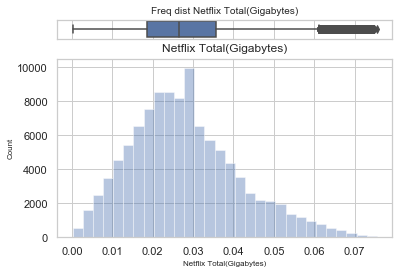

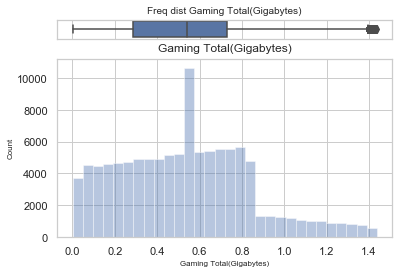

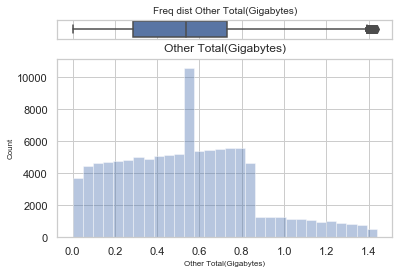

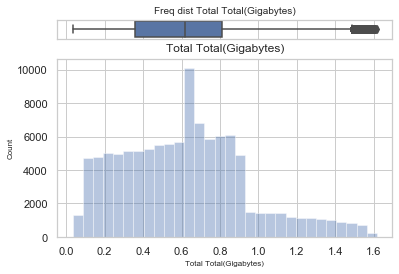

In [9]:
for x in plot_list:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
    sns.boxplot(data[x], ax=ax_box,color="b")
    sns.distplot(data[x], ax=ax_hist,kde=False,bins=30,color="b")
    ax_box.set_title('Freq dist '+ x , fontsize=10)
    ax_hist.set_xlabel(x , fontsize=8)
    ax_hist.set_ylabel('Count', fontsize=8)
    plt.show()

#### Bivariate Analysis

In [10]:
apps_plot_list = list(data.iloc[:,20:27].columns)

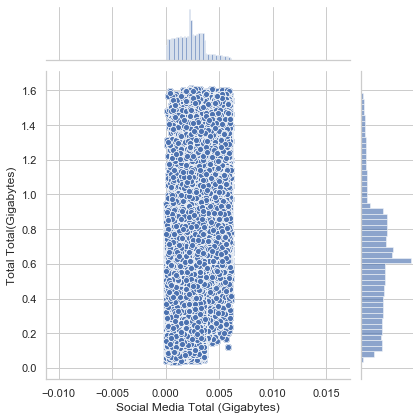

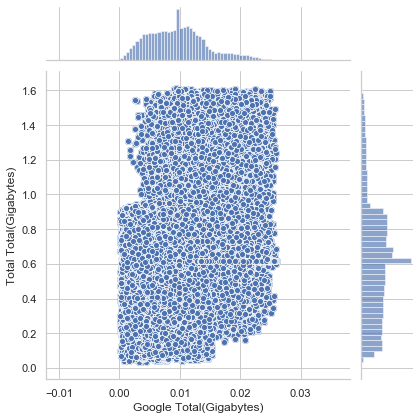

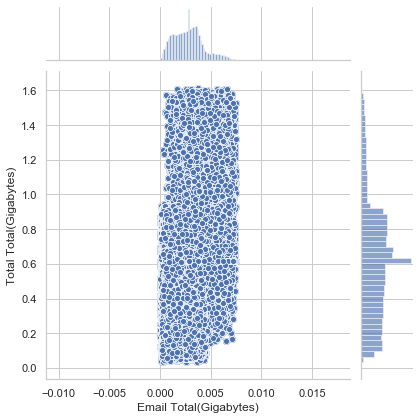

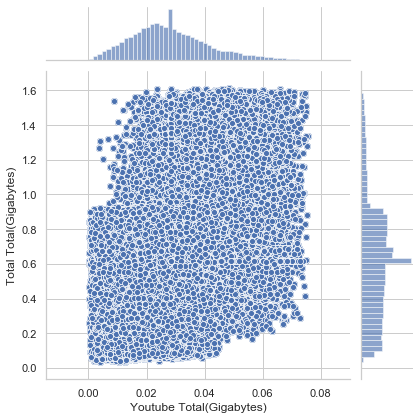

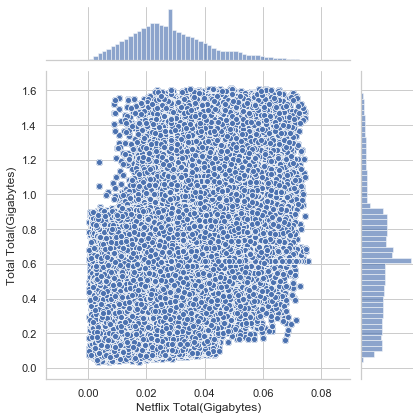

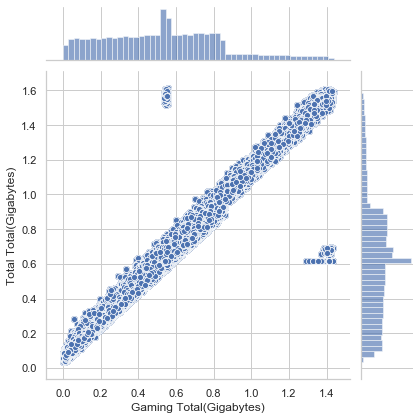

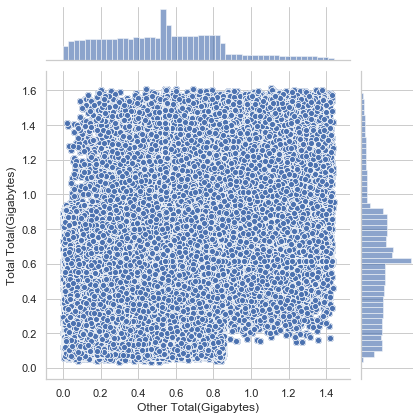

In [11]:
for x in apps_plot_list:
    g = sns.jointplot(x=x, y='Total Total(Gigabytes)', data=data)
    g = g.plot_joint(sns.scatterplot, color="b")
    g = g.plot_marginals(sns.distplot, kde=False, color="b")
    plt.show()

#### Variable transformations

In [12]:
decile= data.copy()
decile = decile.sort_values(by='Dur. (min)', ascending=False)
deciles=[.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.]
decile['Decile_rank'] = pd.qcut(decile['Dur. (min)'],labels=False,q=deciles,duplicates='drop')
decile = decile.groupby('Decile_rank',as_index=False).agg('sum')
decile = decile.sort_values(by='Dur. (min)', ascending=False)

In [13]:
top_decile = decile[decile['Decile_rank']>= 4]
top_decile = top_decile.loc[:,('Total Total(Gigabytes)','Decile_rank')]

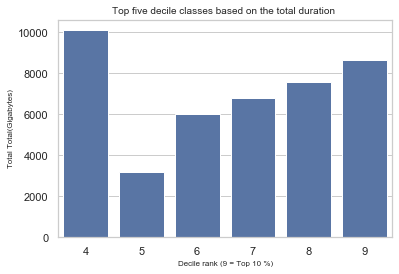

In [14]:
f, ax = plt.subplots()
sns.barplot(x="Decile_rank", y="Total Total(Gigabytes)", data=top_decile, color="b")
ax.set_title('Top five decile classes based on the total duration ', fontsize=10)
ax.set_xlabel("Decile rank (9 = Top 10 %)", fontsize=8)
ax.set_ylabel("Total Total(Gigabytes)", fontsize=8)
plt.show()

#### Multivariate Analysis

##### Correlation

In [15]:
corr_data = data.iloc[:,20:].corr()

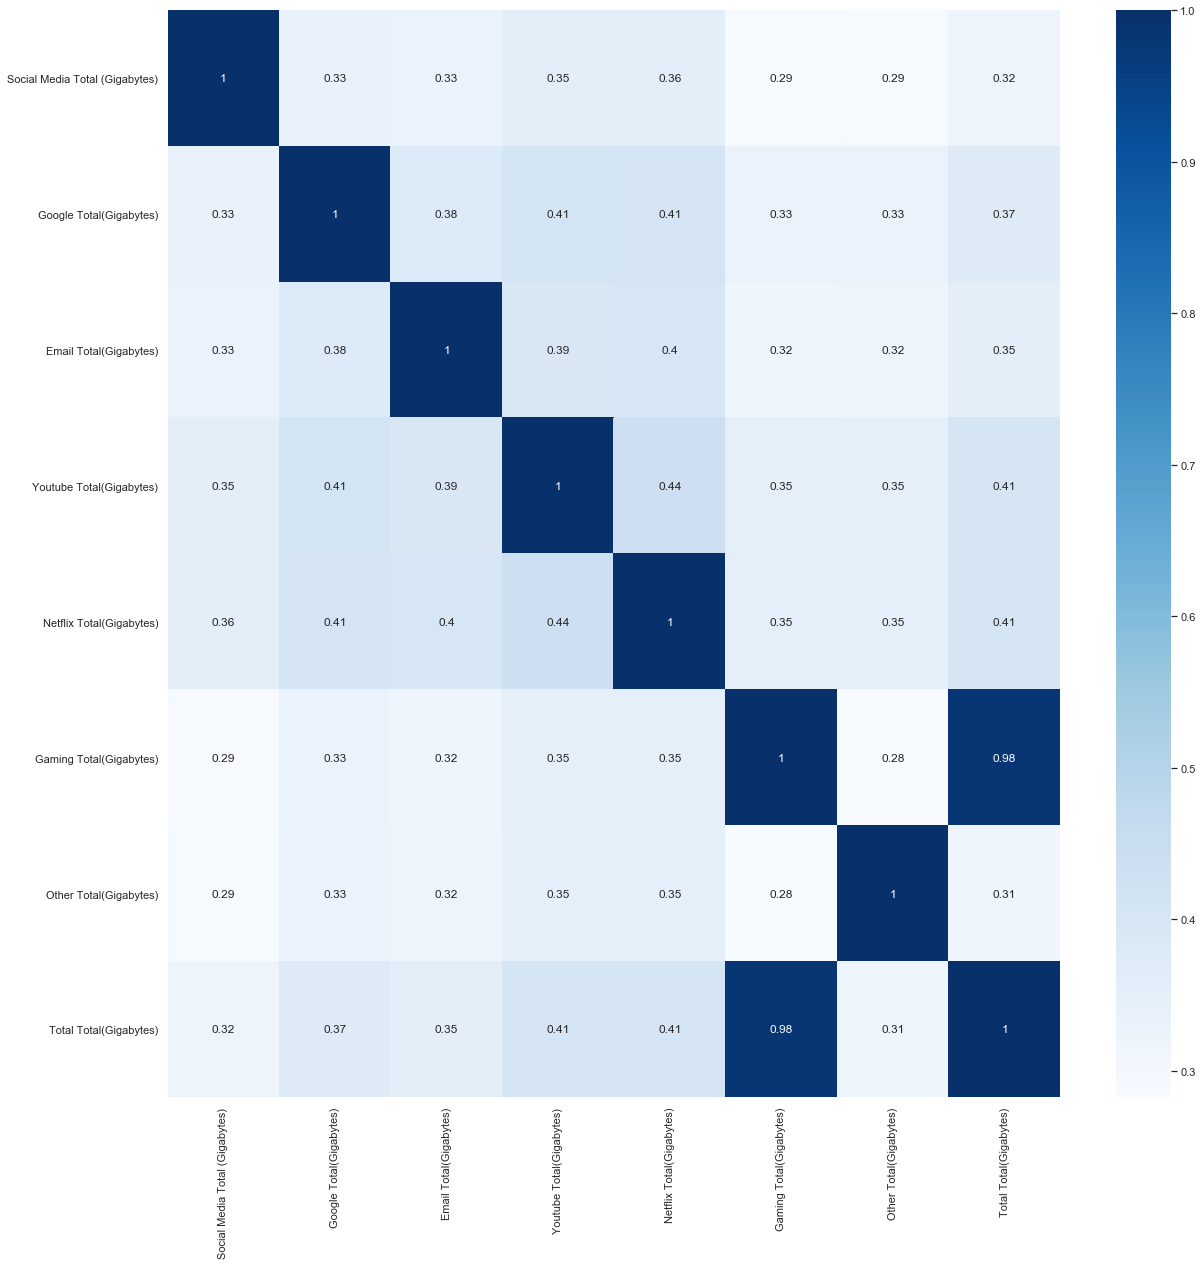

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_data,cmap='Blues',annot=True) 

##### Crossplots

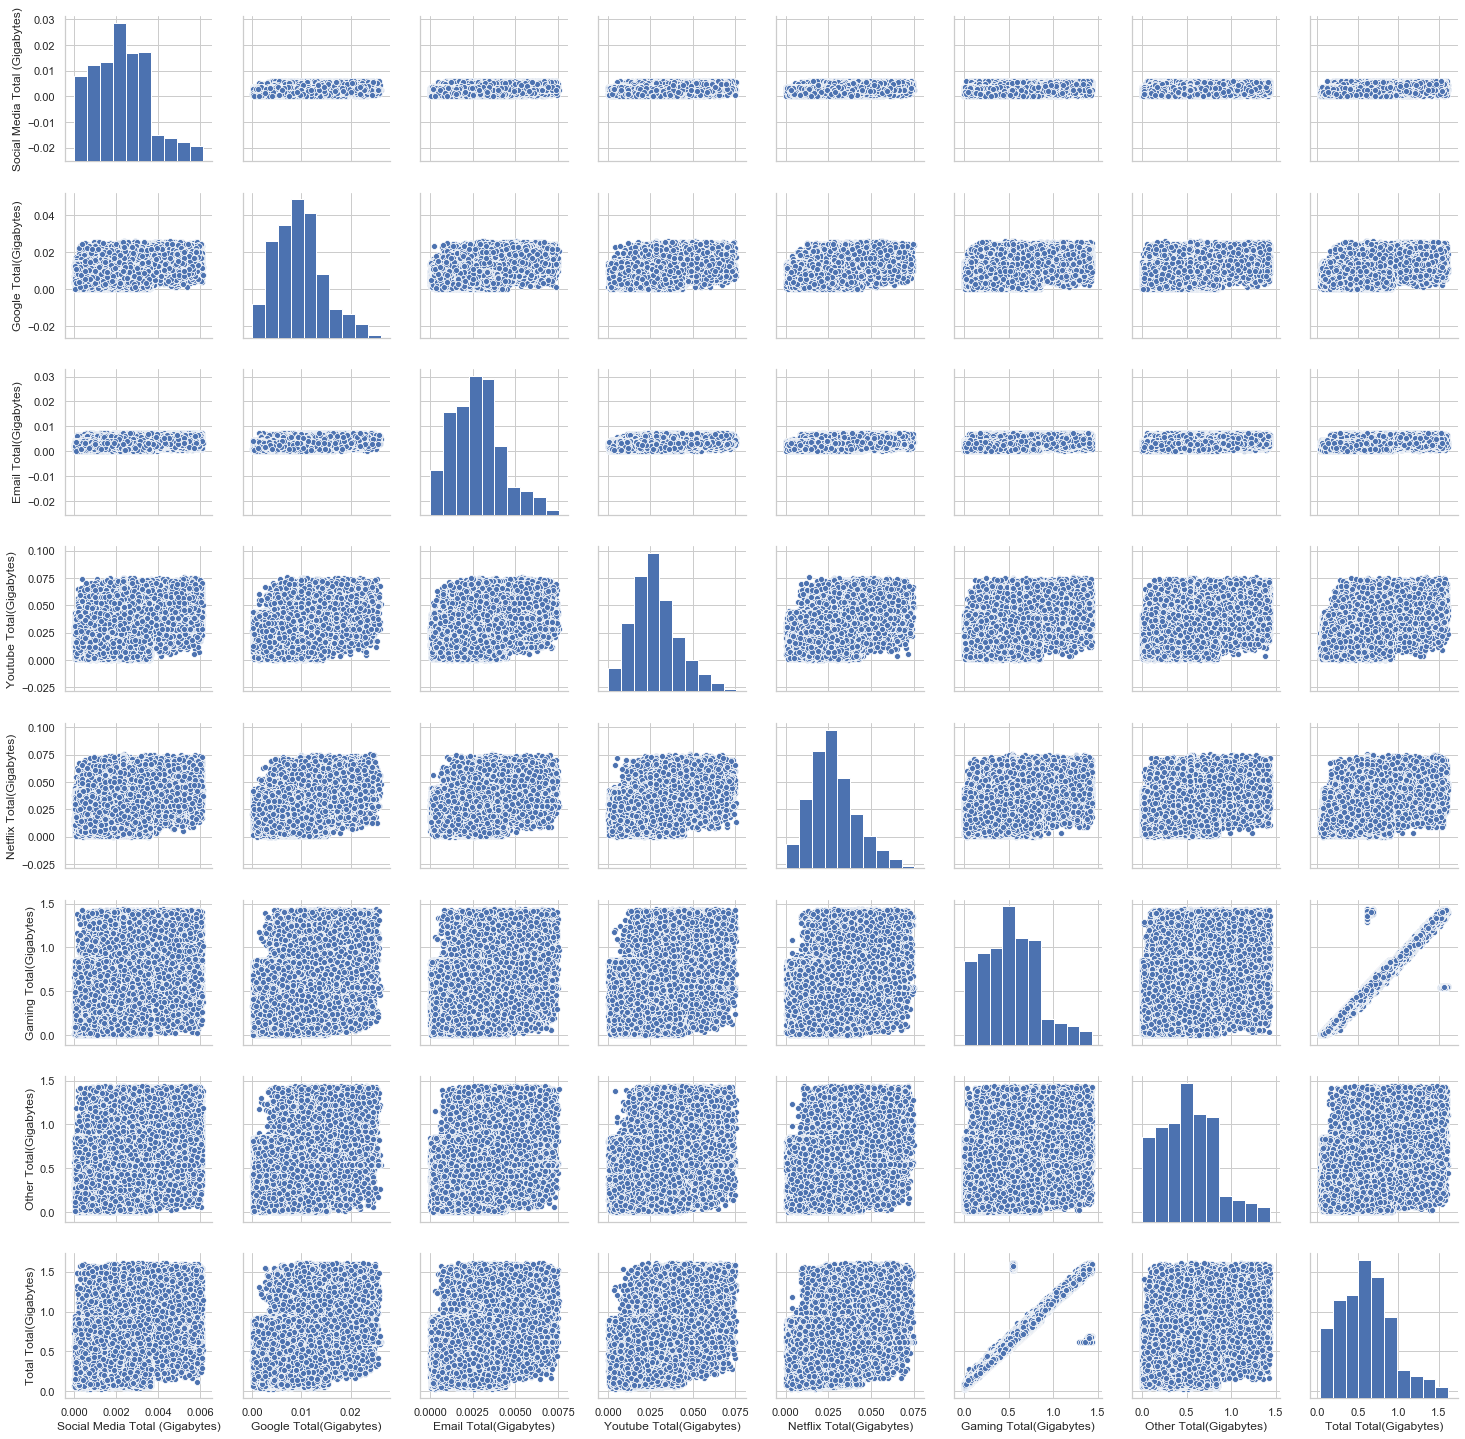

In [17]:
sns.pairplot(data=data.iloc[:,20:])
plt.show()

#### Dimensionality Reduction

In [18]:
dr_data = data.copy()
dr_data = dr_data.iloc[:,19:]
dr_data = dr_data.dropna()

In [19]:
X = dr_data.iloc[:,1:8].values
y = dr_data.iloc[:,8].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
pca = PCA(n_components=7)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

regressor = LinearRegression()  
#training the algorithm
regressor.fit(X_train, y_train) 

# Predicting the Test set results
y_pred = regressor.predict(X_test)

LinAlgError: SVD did not converge

In [ ]:
results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

Result_coeff = pd.DataFrame(regressor.coef_,dr_data.iloc[:,1:8].columns, columns=['Coefficient'])  
Result_coeff

In [ ]:
results_samp = results.sample(25)
results_samp.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
